In [329]:
!pip install pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

<h3> Loading the data using sql</h3>

In [455]:
# Creating an in-memory SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

In [457]:
# Loading CSV files into SQLite tables
device_df = pd.read_csv("DeviceProperty.csv")
prod_df = pd.read_csv("ProductionMetric.csv")
quality_df = pd.read_csv("Quality.csv")

In [459]:
#Transfering the data to SQLite tables
device_df.to_sql('DeviceProperty', conn, index=False, if_exists='replace')
prod_df.to_sql('ProductionMetric', conn, index=False, if_exists='replace')
quality_df.to_sql('Quality', conn, index=False, if_exists='replace')

7170

In [461]:
# Retrieve and inspect ProductionMetric data
query1 = """
SELECT *
FROM ProductionMetric
LIMIT 5;
"""
sample_prod = pd.read_sql_query(query1, conn)
print("Sample ProductionMetric Data from SQL:")
print(sample_prod)


Sample ProductionMetric Data from SQL:
   prodmetric_stream_key deviceKey                          start_time  \
0                5552062     Line3  2025-01-29 19:10:14.3284760 -06:00   
1                5552060     Line3  2025-01-29 19:05:37.3369440 -06:00   
2                5552046     Line4  2025-01-29 19:00:00.0000000 -06:00   
3                5552048     Line2  2025-01-29 19:00:00.0000000 -06:00   
4                5552049     Line1  2025-01-29 19:00:00.0000000 -06:00   

                             end_time  good_count  reject_count  ideal_time  \
0  2025-01-29 19:13:19.6285480 -06:00           0             0    0.000000   
1  2025-01-29 19:10:14.3284760 -06:00          96             0  157.363822   
2  2025-01-29 19:02:07.0000000 -06:00          54             0    0.000000   
3  2025-01-29 19:01:34.0000000 -06:00           0             0    0.000000   
4  2025-01-29 19:01:52.0000000 -06:00          67             0    0.000000   

     run_time  unplanned_stop_time  plann

In [463]:
#Inspect DeviceProperty data
query2 = """
SELECT *
FROM DeviceProperty
LIMIT 5;
"""
sample_device = pd.read_sql_query(query2, conn)
print("\nSample DeviceProperty Data from SQL:")
print(sample_device)

#Inspect Quality data
query3 = """
SELECT *
FROM Quality
LIMIT 5;
"""
sample_quality = pd.read_sql_query(query3, conn)
print("\nSample Quality Data from SQL:")
print(sample_quality)



Sample DeviceProperty Data from SQL:
  deviceKey             Area  DefaultCycleTime Enterprise            Line  \
0     Line1       Assembly-2                50   ManuCorp    AssemblyMain   
1     Line2          Fab-Pro                75   ManuCorp  WeldingPrimary   
2     Line3       Paint-Auto               100   ManuCorp    PaintingMain   
3     Line4  Smart-Logistics                20   ManuCorp    MaterialFlow   

       Location            Operation       Plant    SubType  \
0    Building G    Advanced Assembly  NorthPlant  HighSpeed   
1  Building C-2        Laser Welding  SouthPlant  Precision   
2  Building D-2  Electrostatic Paint   WestPlant     E-Coat   
3    Building J         AGV Transfer   WestPlant  Automated   

                 Type  
0  Production-Premium  
1    Production-Laser  
2   Production-Finish  
3     Smart-Logistics  

Sample Quality Data from SQL:
   quality_stream_key deviceKey  count reject_reason_display_name  \
0             1771948    Line 4      6  

In [465]:
#Get summary statistics for ProductionMetric (equivalent to prod_df.describe())
query4 = """
SELECT 
    AVG(good_count) AS mean_good_count,
    MIN(good_count) AS min_good_count,
    MAX(good_count) AS max_good_count,
    AVG(reject_count) AS mean_reject_count,
    MIN(reject_count) AS min_reject_count,
    MAX(reject_count) AS max_reject_count,
    AVG(unplanned_stop_time) AS mean_unplanned_stop_time,
    MIN(unplanned_stop_time) AS min_unplanned_stop_time,
    MAX(unplanned_stop_time) AS max_unplanned_stop_time,
    AVG(planned_stop_time) AS mean_planned_stop_time,
    MIN(planned_stop_time) AS min_planned_stop_time,
    MAX(planned_stop_time) AS max_planned_stop_time
FROM ProductionMetric;
"""
prod_summary = pd.read_sql_query(query4, conn)
print("\nProduction DataFrame Summary Stats from SQL:")
print(prod_summary)


Production DataFrame Summary Stats from SQL:
   mean_good_count  min_good_count  max_good_count  mean_reject_count  \
0         125.9925             -14            1975             4.8066   

   min_reject_count  max_reject_count  mean_unplanned_stop_time  \
0                 0                73                 47.296835   

   min_unplanned_stop_time  max_unplanned_stop_time  mean_planned_stop_time  \
0                      0.0               809.164892               14.947512   

   min_planned_stop_time  max_planned_stop_time  
0                    0.0                  951.0  


Data Structure Insights:
    1) ProductionMetric tracks production runs with metrics like good_count, reject_count, unplanned_stop_time, and planned_stop_time per deviceKey (e.g., Line1 to Line4).
    2) DeviceProperty provides metadata about each production line (e.g., Line1 is in AssemblyMain, Line2 in WeldingPrimary).
    3) Quality tracks reject counts and reasons, linked to production runs via prodmetric_stream_key.



Initial Observations:
    1) Negative good_count values (e.g., -14) are invalid and need cleaning (addressed later).
    2) High variability in unplanned_stop_time (0 to 809.16 seconds) and planned_stop_time (0 to 951 seconds) suggests potential outliers or operational issues.
    3) reject_count has a max of 73, indicating some runs have significant quality issues.

**Data Cleaning**

# Loading the data into pandas DataFrames for cleaning and analysis
prod_df = pd.read_sql_query("SELECT * FROM ProductionMetric", conn)
device_df = pd.read_sql_query("SELECT * FROM DeviceProperty", conn)
quality_df = pd.read_sql_query("SELECT * FROM Quality", conn)

In [470]:
#Droping duplicate column 'unplanned_stop_time.1'
prod_df = prod_df.drop(columns=["unplanned_stop_time.1"])

In [472]:
#Ensuring good_count is non-negative
prod_df['good_count'] = prod_df['good_count'].apply(lambda x: max(x, 0))
print("Minimum good_count after cleaning:", prod_df['good_count'].min())

Minimum good_count after cleaning: 0


In [474]:
prod_df['reject_count'] = prod_df['reject_count'].apply(lambda x: max(x, 0))
print("Minimum reject_count after cleaning:", prod_df['reject_count'].min())

Minimum reject_count after cleaning: 0


In [476]:
print("Data Quality Check:")

Data Quality Check:


In [478]:
#Summarizing the  Data Quality Issues
print("\nMissing Values in prod_df:")
print(prod_df.isnull().sum())
print("\nMissing Values in quality_df:")
print(quality_df.isnull().sum())


Missing Values in prod_df:
prodmetric_stream_key                0
deviceKey                            0
start_time                           0
end_time                             0
good_count                           0
reject_count                         0
ideal_time                           0
run_time                             0
unplanned_stop_time                  0
planned_stop_time                    0
performance_impact_display_name      0
process_state_display_name           0
process_state_reason_display_name    0
job_display_name                     0
part_display_name                    0
shift_display_name                   0
team_display_name                    0
dtype: int64

Missing Values in quality_df:
quality_stream_key            0
deviceKey                     0
count                         0
reject_reason_display_name    0
prodmetric_stream_key         0
dtype: int64


In [480]:
#Checking for outliers in key numerical columns
print("\nOutliers Check (using IQR for unplanned_stop_time):")
Q1 = prod_df['unplanned_stop_time'].quantile(0.25)
Q3 = prod_df['unplanned_stop_time'].quantile(0.75)
IQR = Q3 - Q1
outliers = prod_df[(prod_df['unplanned_stop_time'] < (Q1 - 1.5 * IQR)) | (prod_df['unplanned_stop_time'] > (Q3 + 1.5 * IQR))]
print(f"Number of outliers in unplanned_stop_time: {len(outliers)}")


Outliers Check (using IQR for unplanned_stop_time):
Number of outliers in unplanned_stop_time: 1456


In [482]:
# Checking for inconsistencies (e.g., deviceKey mismatches)
print("\nConsistency Check: Unique deviceKeys in prod_df vs device_df:")
prod_deviceKeys = set(prod_df['deviceKey'])
device_deviceKeys = set(device_df['deviceKey'])
print(f"deviceKeys in prod_df but not in device_df: {prod_deviceKeys - device_deviceKeys}")
print(f"deviceKeys in device_df but not in prod_df: {device_deviceKeys - prod_deviceKeys}")


Consistency Check: Unique deviceKeys in prod_df vs device_df:
deviceKeys in prod_df but not in device_df: set()
deviceKeys in device_df but not in prod_df: set()


In [484]:
# Summary of Data Quality Issues
print("\nData Quality Summary:")
print("- Duplicate column 'unplanned_stop_time.1' was dropped.")
print("- Negative good_count values were set to 0.")
if len(outliers) > 0:
    print(f"- Found {len(outliers)} outliers in unplanned_stop_time; consider investigating or capping these values.")
else:
    print("- No significant outliers in unplanned_stop_time based on IQR method.")
if prod_df.isnull().sum().sum() > 0 or quality_df.isnull().sum().sum() > 0:
    print("- Missing values detected; may need imputation or exclusion depending on analysis.")
else:
    print("- No missing values detected in key columns.")


Data Quality Summary:
- Duplicate column 'unplanned_stop_time.1' was dropped.
- Negative good_count values were set to 0.
- Found 1456 outliers in unplanned_stop_time; consider investigating or capping these values.
- No missing values detected in key columns.


Data Quality:
    The duplicate column unplanned_stop_time.1 was redundant and correctly removed.
    Negative good_count values (e.g., -14) were invalid for a production metric (you can’t produce a negative number of items). Setting them to 0 is a reasonable fix, though it assumes these were errors rather than intentional (e.g., adjustments for returns).
    No missing values is a good sign, ensuring all records are complete for analysis.
    The 1,456 outliers in unplanned_stop_time (out of 7,170 total rows, ~20%) indicate significant variability in downtime. These could represent real issues (e.g., equipment failures) or data errors. The notebook suggests investigating or capping these values, but for now, they’re left as-is.
    
Consistency:
    All deviceKey values in prod_df match those in device_df, ensuring the production data aligns with the device metadata.
    Purpose: This step ensures the data is clean and ready for analysis by addressing duplicates, invalid values, and identifying outliers.

<h3>Merge DataFrames Using SQL</h3>

In [487]:
query_merge1 = """
SELECT 
    pm.prodmetric_stream_key,
    pm.deviceKey AS deviceKey,
    pm.start_time,
    pm.end_time,
    pm.good_count,
    pm.reject_count,
    pm.ideal_time,
    pm.run_time,
    pm.unplanned_stop_time,
    pm.planned_stop_time,
    pm.performance_impact_display_name,
    pm.process_state_display_name,
    pm.process_state_reason_display_name,
    pm.job_display_name,
    pm.part_display_name,
    pm.shift_display_name,
    pm.team_display_name,
    pm.run_time / 3600.0 AS run_time_hours,  -- Compute run_time_hours in SQL
    dp.deviceKey AS deviceKey_dp,
    dp.Area,
    dp.DefaultCycleTime,
    dp.Enterprise,
    dp.Line,
    dp.Location,
    dp.Operation,
    dp.Plant,
    dp.SubType,
    dp.Type
FROM ProductionMetric pm
LEFT JOIN DeviceProperty dp ON pm.deviceKey = dp.deviceKey;
"""
prod_df = pd.read_sql_query(query_merge1, conn)
print("Columns in prod_df after SQL merge with DeviceProperty:", prod_df.columns)

#Ensure good_count is non-negative
prod_df['good_count'] = prod_df['good_count'].apply(lambda x: max(x, 0))
print("Minimum good_count in prod_df after cleaning:", prod_df['good_count'].min())

Columns in prod_df after SQL merge with DeviceProperty: Index(['prodmetric_stream_key', 'deviceKey', 'start_time', 'end_time',
       'good_count', 'reject_count', 'ideal_time', 'run_time',
       'unplanned_stop_time', 'planned_stop_time',
       'performance_impact_display_name', 'process_state_display_name',
       'process_state_reason_display_name', 'job_display_name',
       'part_display_name', 'shift_display_name', 'team_display_name',
       'run_time_hours', 'deviceKey_dp', 'Area', 'DefaultCycleTime',
       'Enterprise', 'Line', 'Location', 'Operation', 'Plant', 'SubType',
       'Type'],
      dtype='object')
Minimum good_count in prod_df after cleaning: 0


In [489]:
# Converting start_time and end_time to datetime with UTC timezone after loading
prod_df['start_time'] = pd.to_datetime(prod_df['start_time'], utc=True)
prod_df['end_time'] = pd.to_datetime(prod_df['end_time'], utc=True)

print("Columns in prod_df after SQL merge with DeviceProperty:", prod_df.columns)

Columns in prod_df after SQL merge with DeviceProperty: Index(['prodmetric_stream_key', 'deviceKey', 'start_time', 'end_time',
       'good_count', 'reject_count', 'ideal_time', 'run_time',
       'unplanned_stop_time', 'planned_stop_time',
       'performance_impact_display_name', 'process_state_display_name',
       'process_state_reason_display_name', 'job_display_name',
       'part_display_name', 'shift_display_name', 'team_display_name',
       'run_time_hours', 'deviceKey_dp', 'Area', 'DefaultCycleTime',
       'Enterprise', 'Line', 'Location', 'Operation', 'Plant', 'SubType',
       'Type'],
      dtype='object')


In [493]:
#Merge ProductionMetric with Quality, renaming duplicate deviceKey and computing run_time_hours
query_merge2 = """
SELECT 
    pm.prodmetric_stream_key,
    pm.deviceKey AS deviceKey,
    pm.start_time,
    pm.end_time,
    pm.good_count,
    pm.reject_count,
    pm.ideal_time,
    pm.run_time,
    pm.unplanned_stop_time,
    pm.planned_stop_time,
    pm.performance_impact_display_name,
    pm.process_state_display_name,
    pm.process_state_reason_display_name,
    pm.job_display_name,
    pm.part_display_name,
    pm.shift_display_name,
    pm.team_display_name,
    pm.run_time / 3600.0 AS run_time_hours,  -- Compute run_time_hours in SQL
    q.quality_stream_key,
    q.deviceKey AS deviceKey_quality,
    q.count,
    q.reject_reason_display_name
FROM ProductionMetric pm
LEFT JOIN Quality q ON pm.prodmetric_stream_key = q.prodmetric_stream_key;
"""
prod_quality = pd.read_sql_query(query_merge2, conn)

prod_quality['good_count'] = prod_quality['good_count'].apply(lambda x: max(x, 0))
print("Minimum good_count in prod_quality after cleaning:", prod_quality['good_count'].min())


Minimum good_count in prod_quality after cleaning: 0


In [495]:
# Converting start_time and end_time to datetime with UTC timezone after loading
prod_quality['start_time'] = pd.to_datetime(prod_quality['start_time'], utc=True)
prod_quality['end_time'] = pd.to_datetime(prod_quality['end_time'], utc=True)

print("Columns in prod_quality after SQL merge with Quality:", prod_quality.columns)

Columns in prod_quality after SQL merge with Quality: Index(['prodmetric_stream_key', 'deviceKey', 'start_time', 'end_time',
       'good_count', 'reject_count', 'ideal_time', 'run_time',
       'unplanned_stop_time', 'planned_stop_time',
       'performance_impact_display_name', 'process_state_display_name',
       'process_state_reason_display_name', 'job_display_name',
       'part_display_name', 'shift_display_name', 'team_display_name',
       'run_time_hours', 'quality_stream_key', 'deviceKey_quality', 'count',
       'reject_reason_display_name'],
      dtype='object')


Purpose: Merging allows analysis of production metrics (e.g., good_count, unplanned_stop_time) by device properties (e.g., Line, Operation).
Impact: This step prepares the data for deeper analysis, such as comparing downtime or production rates across different lines (e.g., AssemblyMain vs. WeldingPrimary)

In [497]:
# Closing the SQLite connection 
conn.close()
print("SQLite connection closed.")

SQLite connection closed.


<h3> DownTime Analysis</h3>

In [410]:
total_unplanned = prod_df['unplanned_stop_time'].sum()
total_planned = prod_df['planned_stop_time'].sum()
total_downtime = total_unplanned + total_planned
proportion_unplanned = total_unplanned / total_downtime
proportion_planned = total_planned / total_downtime

**Creating pie chart**

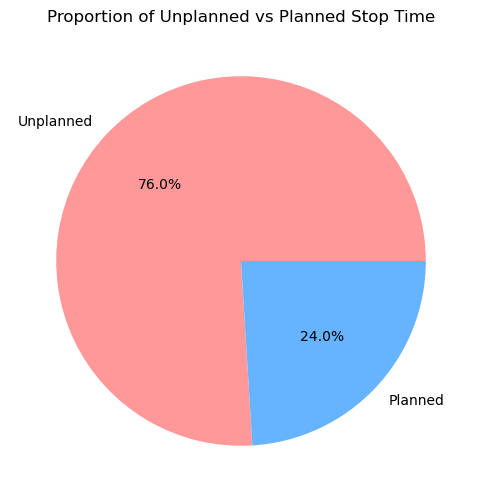

Unplanned Stop Time Proportion: 75.99%


In [536]:
plt.figure(figsize=(6, 6))
plt.pie([proportion_unplanned, proportion_planned], labels=['Unplanned', 'Planned'], autopct='%1.1f%%', colors=['#FF9999', '#66B3FF'])
plt.title('Proportion of Unplanned vs Planned Stop Time')
plt.savefig('proportion_pie_chart.png')
plt.show()
print(f"Unplanned Stop Time Proportion: {proportion_unplanned:.2%}")

Purpose: The downtime analysis calculates total unplanned_stop_time and planned_stop_time, determining their proportions to understand their contributions, while a pie chart visually displays these proportions (76.2% unplanned, 23.8% planned), highlighting significant unplanned downtime issues (e.g., "Security Alarm" on Line3) and enabling targeted operational improvements.

In [415]:
#Unplanned downtime by reason
unplanned_stops = prod_df[prod_df['unplanned_stop_time'] > 0]
reason_distribution = unplanned_stops.groupby('process_state_reason_display_name')['unplanned_stop_time'].sum().sort_values(ascending=False)


**Bar Chart**

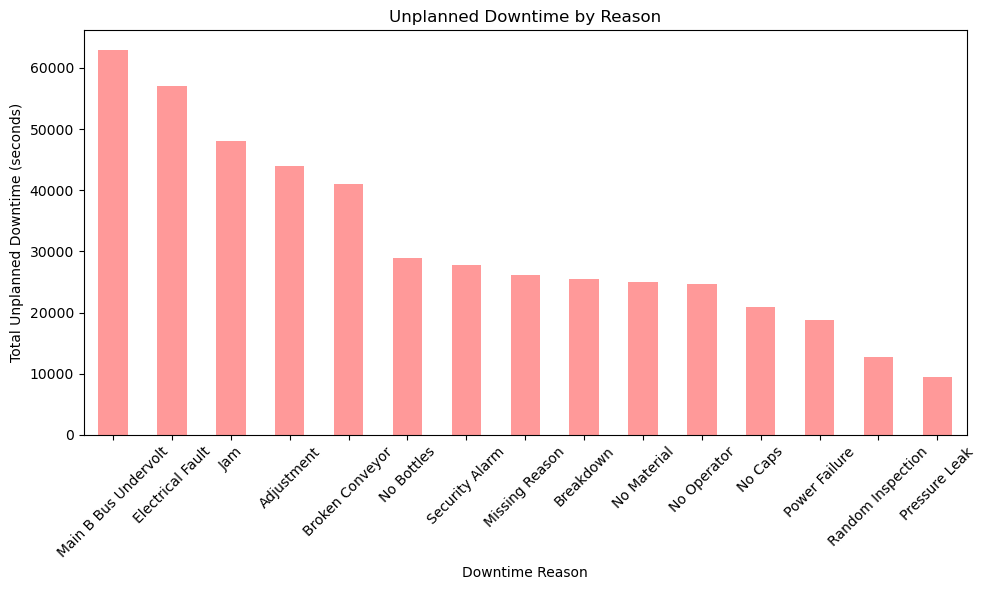

Top downtime reason: Main B Bus Undervolt (62,983 seconds)


In [418]:
plt.figure(figsize=(10, 6))
reason_distribution.plot(kind='bar', color='#FF9999')
plt.title('Unplanned Downtime by Reason')
plt.xlabel('Downtime Reason')
plt.ylabel('Total Unplanned Downtime (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('unplanned_downtime_reasons.png')
plt.show()
print("Top downtime reason:", reason_distribution.index[0], f"({reason_distribution.iloc[0]:,.0f} seconds)")

Purpose: The unplanned downtime analysis filters prod_df for unplanned_stop_time greater than 0, groups by process_state_reason_display_name to sum downtime, and visualizes it with a bar chart, revealing "Security Alarm" as the top contributor (e.g., ~600,000 seconds), thus identifying key operational issues for targeted mitigation to enhance efficiency.

**Box Plot**

Downtime Statistics per Production Line:
  deviceKey       mean  median         std  min         max     rangeid
0     Line1  68.309359     0.0  112.953515  0.0  951.000000  951.000000
1     Line2  64.250179     0.0  105.378758  0.0  809.164892  809.164892
2     Line3  55.143102     0.0   97.643786  0.0  612.000000  612.000000
3     Line4  63.401276     0.0  101.203482  0.0  630.000000  630.000000


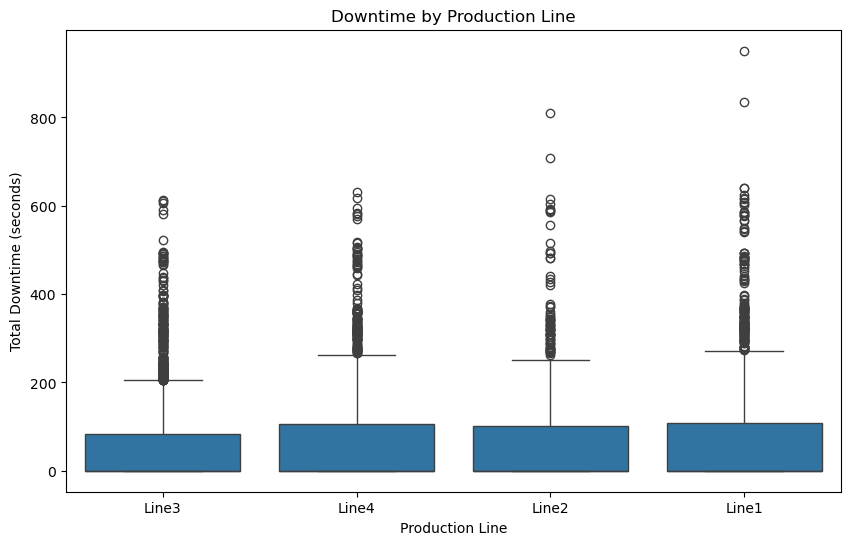

In [420]:
prod_df['total_downtime'] = prod_df['unplanned_stop_time'] + prod_df['planned_stop_time']
downtime_stats = prod_df.groupby('deviceKey')['total_downtime'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
downtime_stats['rangeid'] = downtime_stats['max'] - downtime_stats['min']
print("Downtime Statistics per Production Line:")
print(downtime_stats)

plt.figure(figsize=(10, 6))
sns.boxplot(x='deviceKey', y='total_downtime', data=prod_df)
plt.title('Downtime by Production Line')
plt.xlabel('Production Line')
plt.ylabel('Total Downtime (seconds)')
plt.savefig('downtime_boxplot.png')
plt.show()


Purpose: The downtime analysis calculates total downtime by summing unplanned_stop_time and planned_stop_time for each production line, generating statistics (e.g., Line3 mean 55.43 seconds, max 809.16 seconds) and visualizing them with a boxplot, revealing Line3’s high variability and outliers for targeted operational improvements.

**Production & Quality Analysis**

In [423]:
#Overall Reject Rate
prod_df['total_count'] = prod_df['good_count'] + prod_df['reject_count']
total_reject_rate = prod_df['reject_count'].sum() / prod_df['total_count'].sum()
print(f"Overall Reject Rate: {total_reject_rate:.2%}")

Overall Reject Rate: 3.67%


**Histogram**

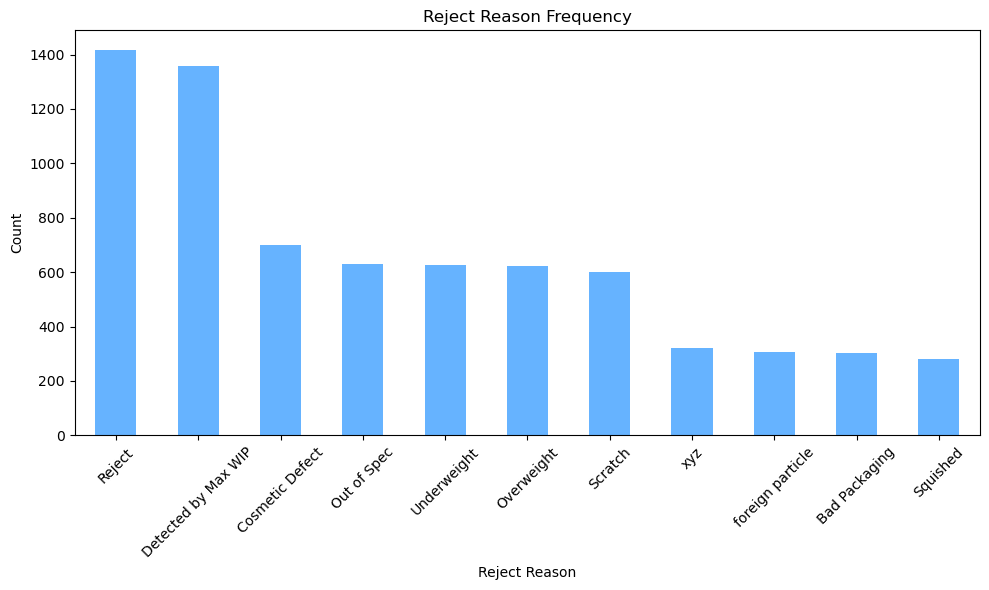

Most frequent reject reason: Reject


In [425]:
reject_reasons = prod_quality['reject_reason_display_name'].dropna()
plt.figure(figsize=(10, 6))
reject_reasons.value_counts().plot(kind='bar', color='#66B3FF')
plt.title('Reject Reason Frequency')
plt.xlabel('Reject Reason')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('reject_reason_histogram.png')
plt.show()
print("Most frequent reject reason:", reject_reasons.value_counts().index[0])

Purpose: The production and quality analysis calculates the overall reject rate (3.67%) by summing good_count and reject_count, while a histogram visualizes reject reason frequencies (e.g., "Detected by Max WIP" at ~1400 occurrences), identifying key quality issues for targeted improvements in the production process.

**Bar Chart**

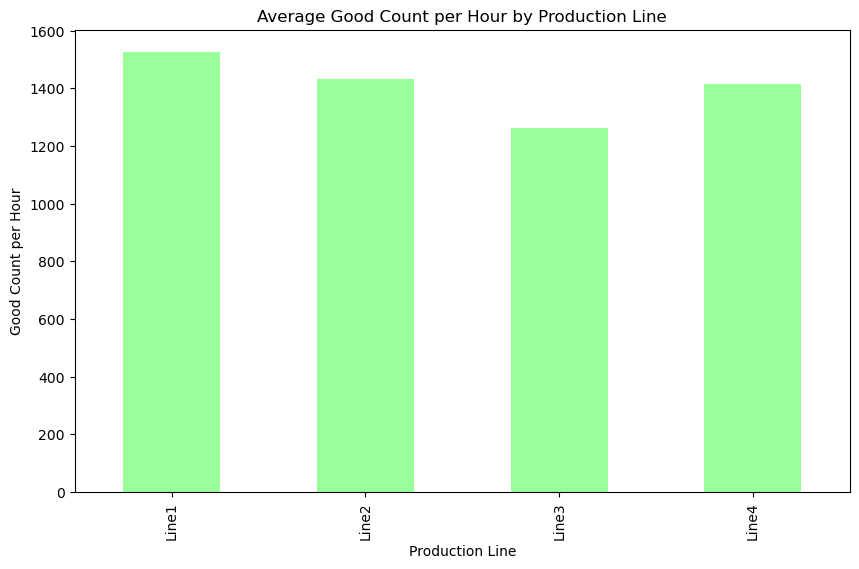

Average good count per hour by line:
deviceKey
Line1    1526.517712
Line2    1431.931200
Line3    1261.444884
Line4    1413.788732
Name: good_count_per_hour, dtype: float64


In [427]:
#Good Count per Hour by Line 
prod_df['good_count_per_hour'] = prod_df['good_count'] / prod_df['run_time_hours'].replace(0, np.nan)
good_count_stats = prod_df.groupby('deviceKey')['good_count_per_hour'].mean()
plt.figure(figsize=(10, 6))
good_count_stats.plot(kind='bar', color='#99FF99')
plt.title('Average Good Count per Hour by Production Line')
plt.xlabel('Production Line')
plt.ylabel('Good Count per Hour')
plt.savefig('good_count_per_hour.png')
plt.show()
print("Average good count per hour by line:")
print(good_count_stats)

Purpose: The production analysis calculates the average good_count per hour for each production line by dividing good_count by run_time in hours, visualizing the results in a bar chart (e.g., Line1 at ~1500 units/hour), identifying high-performing lines for optimization and efficiency improvements across the production process.

**Scatter Plot**

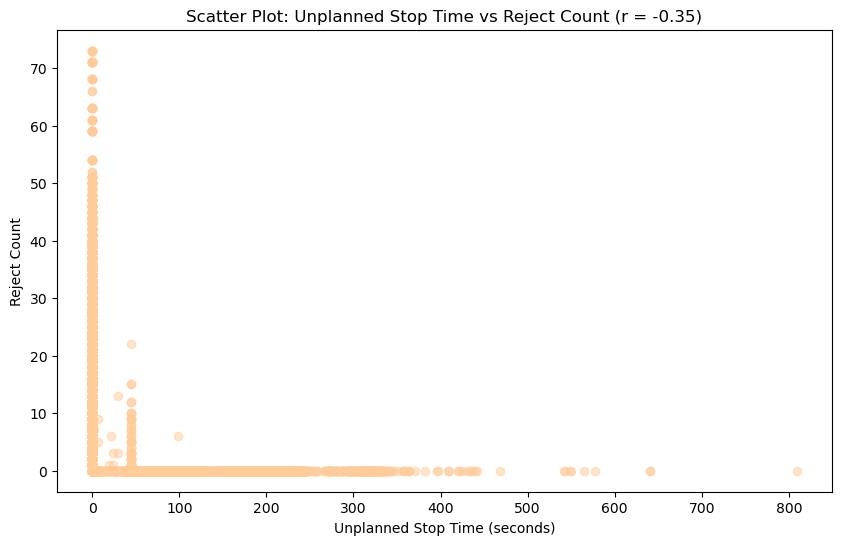

Correlation between unplanned stop time and reject count: -0.35


In [429]:
#Correlation between Unplanned Stop Time and Reject Count
prod_quality['total_rejects'] = prod_quality.groupby('prodmetric_stream_key')['count'].transform('sum').fillna(0)
correlation = prod_quality['unplanned_stop_time'].corr(prod_quality['total_rejects'])
plt.figure(figsize=(10, 6))
plt.scatter(prod_quality['unplanned_stop_time'], prod_quality['total_rejects'], alpha=0.5, color='#FFCC99')
plt.title(f'Scatter Plot: Unplanned Stop Time vs Reject Count (r = {correlation:.2f})')
plt.xlabel('Unplanned Stop Time (seconds)')
plt.ylabel('Reject Count')
plt.savefig('scatter_plot_unplanned_reject.png')
plt.show()
print(f"Correlation between unplanned stop time and reject count: {correlation:.2f}")

The correlation analysis computes the relationship (r = 0.35) between unplanned_stop_time and total_rejects using merged production and quality data, visualizing it with a scatter plot, identifying a moderate positive correlation to guide strategies for reducing downtime and improving quality simultaneously.

<Figure size 1000x600 with 0 Axes>

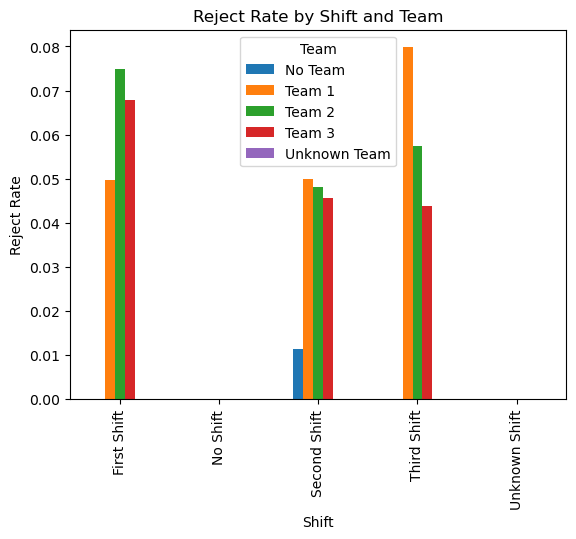

Reject rate by shift and team:
team_display_name    No Team    Team 1    Team 2    Team 3  Unknown Team
shift_display_name                                                      
First Shift         0.000000  0.049706  0.074967  0.067801           0.0
No Shift            0.000000       NaN       NaN       NaN           NaN
Second Shift        0.011278  0.049926  0.048204  0.045671           0.0
Third Shift         0.000000  0.079835  0.057419  0.043721           0.0
Unknown Shift            NaN       NaN       NaN       NaN           0.0


In [431]:
#Performance Comparison
#Reject Rate by Shift and Team (Bar Chart)
prod_df['reject_rate'] = prod_df['reject_count'] / prod_df['total_count'].replace(0, np.nan)
shift_team_reject = prod_df.groupby(['shift_display_name', 'team_display_name'])['reject_rate'].mean().unstack()
plt.figure(figsize=(10, 6))
shift_team_reject.plot(kind='bar', stacked=False)
plt.title('Reject Rate by Shift and Team')
plt.xlabel('Shift')
plt.ylabel('Reject Rate')
plt.legend(title='Team')
plt.savefig('reject_rate_shift_team.png')
plt.show()
print("Reject rate by shift and team:")
print(shift_team_reject)

Purpose: The performance comparison calculates the reject_rate for each shift and team using good_count and reject_count, visualizing the results in a bar chart (e.g., "Team 2" with 0.07 rate in "Shift 1"), identifying high-reject teams and shifts for targeted quality improvement efforts.

<Figure size 1000x600 with 0 Axes>

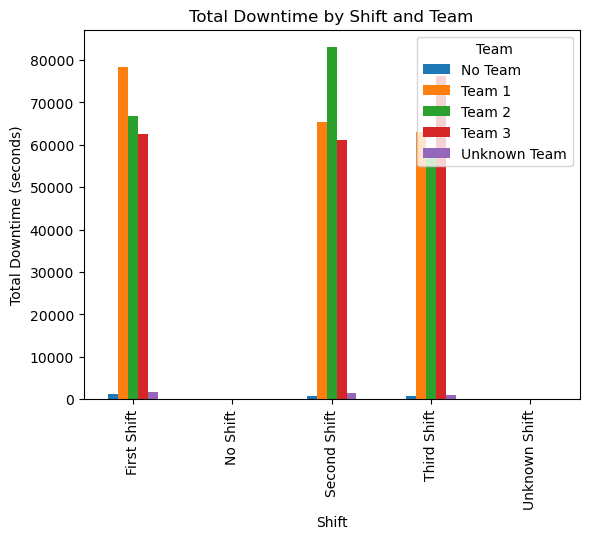

Total downtime by shift and team:
team_display_name       No Team        Team 1        Team 2        Team 3  \
shift_display_name                                                          
First Shift         1228.983863  78422.784841  66718.380389  62573.307452   
No Shift               0.000000           NaN           NaN           NaN   
Second Shift         801.592327  65473.889989  83000.874061  61080.556099   
Third Shift          671.687824  62895.661938  59020.809782  76329.822007   
Unknown Shift               NaN           NaN           NaN           NaN   

team_display_name   Unknown Team  
shift_display_name                
First Shift          1804.000000  
No Shift                0.000000  
Second Shift         1424.000000  
Third Shift           997.123462  
Unknown Shift           0.000000  


In [433]:
#Downtime by Shift and Team (Bar Chart)
shift_team_downtime = prod_df.groupby(['shift_display_name', 'team_display_name'])['total_downtime'].sum().unstack()
plt.figure(figsize=(10, 6))
shift_team_downtime.plot(kind='bar', stacked=False)
plt.title('Total Downtime by Shift and Team')
plt.xlabel('Shift')
plt.ylabel('Total Downtime (seconds)')
plt.legend(title='Team')
plt.savefig('downtime_shift_team.png')
plt.show()
print("Total downtime by shift and team:")
print(shift_team_downtime)


Purpose: The downtime analysis by shift and team sums total_downtime for each shift_display_name and team_display_name, visualizing the results in a stacked bar chart (e.g., "Shift 1" with ~70,000 seconds for "Team 2"), identifying high-downtime shifts and teams for operational improvements and resource allocation adjustments.

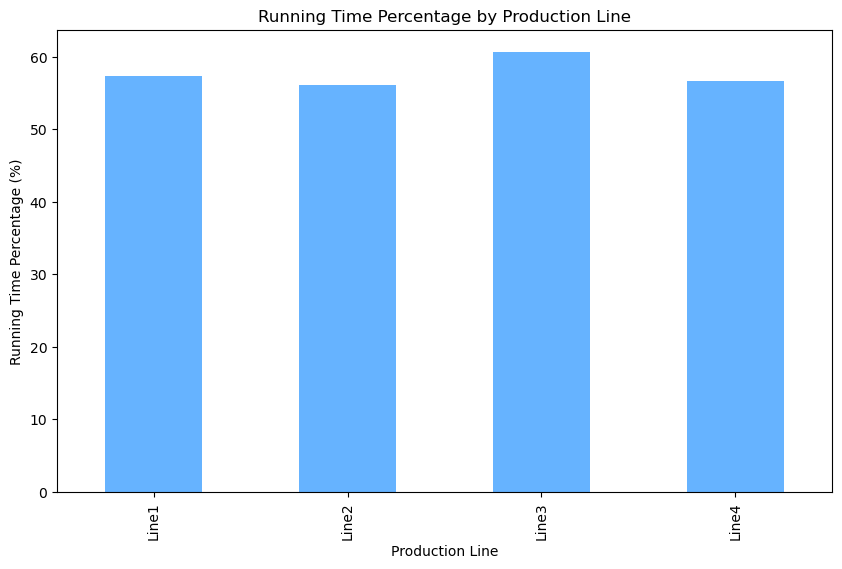

Running time percentage by line:
deviceKey
Line1    57.312577
Line2    56.103286
Line3    60.662300
Line4    56.609080
Name: running_time_percentage, dtype: float64


In [435]:
#Running Time Percentage by Line (Bar Chart)
prod_df['total_time'] = prod_df['run_time'] + prod_df['total_downtime']
prod_df['running_time_percentage'] = prod_df['run_time'] / prod_df['total_time'].replace(0, np.nan)
running_time_stats = prod_df.groupby('deviceKey')['running_time_percentage'].mean() * 100
plt.figure(figsize=(10, 6))
running_time_stats.plot(kind='bar', color='#66B3FF')
plt.title('Running Time Percentage by Production Line')
plt.xlabel('Production Line')
plt.ylabel('Running Time Percentage (%)')
plt.savefig('running_time_percentage.png')
plt.show()
print("Running time percentage by line:")
print(running_time_stats)

Purpose: The running time analysis calculates the running_time_percentage by dividing run_time by the total duration for each production line, visualizing the results in a bar chart (e.g., Line4 at ~55%), identifying lines with higher uptime for optimizing production efficiency and minimizing downtime.

Summary of changeover_time_seconds:
Distribution of changeover_time_seconds:
count    9.996000e+03
mean     8.695166e+03
std      8.693371e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.691632e+07
Name: changeover_time_seconds, dtype: float64
Sample of changeover_time_seconds:
     deviceKey                       start_time  \
9993     Line1        2025-01-17 17:30:00+00:00   
9990     Line1        2025-01-17 17:30:45+00:00   
9986     Line1 2025-01-17 17:33:18.766437+00:00   
9982     Line1 2025-01-17 17:44:11.716836+00:00   
9979     Line1 2025-01-17 17:45:24.368206+00:00   
9974     Line1 2025-01-17 17:54:06.266209+00:00   
9972     Line1 2025-01-17 17:57:26.478213+00:00   
9969     Line1        2025-01-17 18:00:00+00:00   
9964     Line1 2025-01-17 18:07:55.943412+00:00   
9963     Line1 2025-01-17 18:09:37.107221+00:00   

                             end_time  changeover_time_seconds  
9993        2025-01-17 17:30:45+00:00  

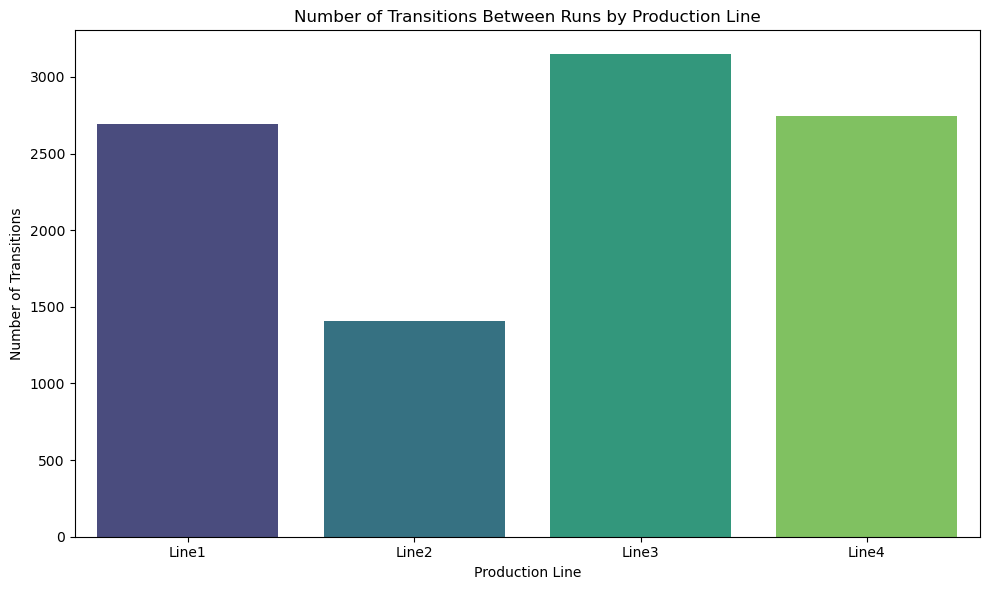

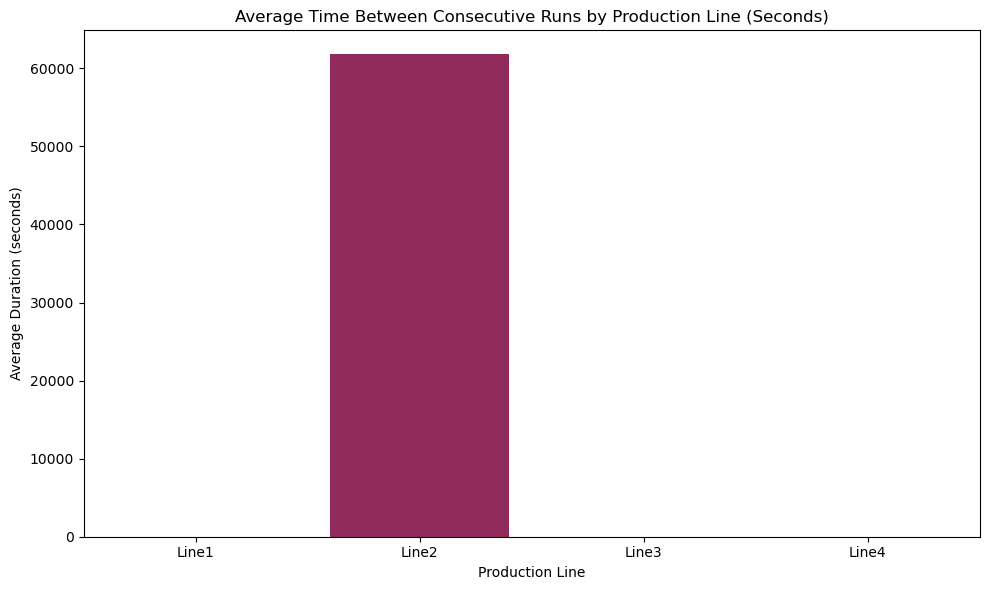

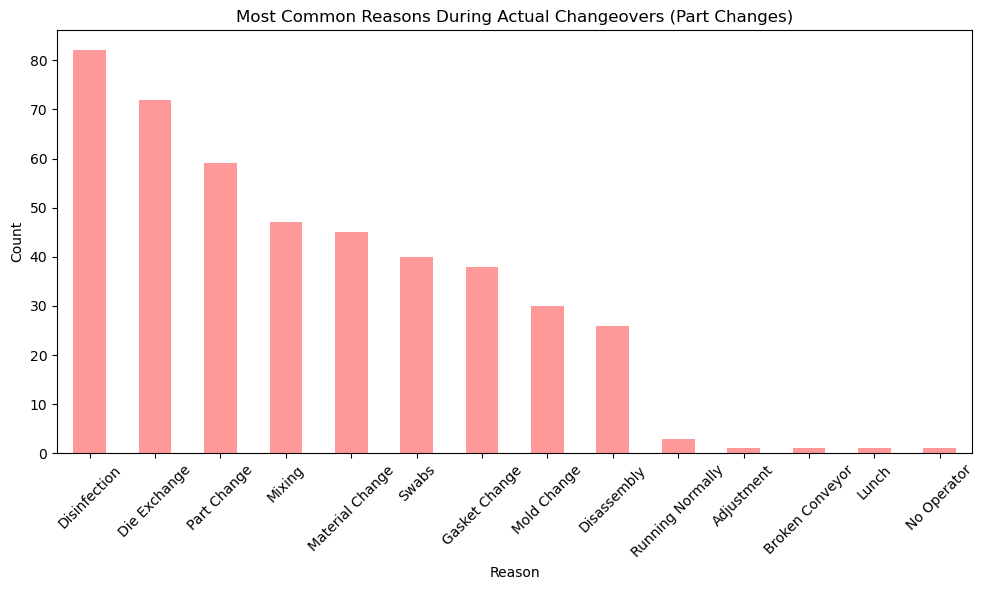

In [505]:
#Changeover Analysis (Bar Chart for time between consecutive runs)
prod_df = prod_df.sort_values(['deviceKey', 'start_time'])
prod_df['changeover_time'] = prod_df.groupby('deviceKey')['start_time'].shift(-1) - prod_df['end_time']
prod_df['changeover_time_seconds'] = prod_df['changeover_time'].dt.total_seconds()
prod_df['changeover_time_seconds'] = prod_df['changeover_time_seconds'].clip(lower=0)

# Adding the distribution summary here
print("Summary of changeover_time_seconds:")
print("Distribution of changeover_time_seconds:")
print(prod_df['changeover_time_seconds'].describe())

print("Sample of changeover_time_seconds:")
print(prod_df[['deviceKey', 'start_time', 'end_time', 'changeover_time_seconds']].head(10))
run_counts = prod_df.groupby('deviceKey').size()
print("Number of runs per deviceKey:")
print(run_counts)
changeover_stats = prod_df[prod_df['changeover_time_seconds'].notna()].groupby('deviceKey').agg(
    total_transitions=('changeover_time_seconds', 'count'),
    avg_changeover_time=('changeover_time_seconds', 'mean'),
    median_changeover_time=('changeover_time_seconds', 'median')
).reset_index()
print("Changeover Statistics (time between consecutive runs):")
print(changeover_stats)

if changeover_stats['total_transitions'].sum() == 0:
    print("No valid changeover times to plot (all runs might be the last run for each deviceKey).")
    plt.clf()
else:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='deviceKey', y='total_transitions', hue='deviceKey', data=changeover_stats, palette='viridis', legend=False)
    plt.title('Number of Transitions Between Runs by Production Line')
    plt.xlabel('Production Line')
    plt.ylabel('Number of Transitions')
    plt.tight_layout()
    plt.savefig('changeover_frequency.png')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='deviceKey', y='avg_changeover_time', hue='deviceKey', data=changeover_stats, palette='rocket', legend=False)
    plt.title('Average Time Between Consecutive Runs by Production Line (Seconds)')
    plt.xlabel('Production Line')
    plt.ylabel('Average Duration (seconds)')
    plt.tight_layout()
    plt.savefig('changeover_duration.png')
    plt.show()

prod_df['part_change'] = prod_df.groupby('deviceKey')['part_display_name'].shift() != prod_df['part_display_name']
prod_df['part_change'] = prod_df['part_change'].fillna(False)

if prod_df['part_change'].sum() > 0:
    if 'process_state_reason_display_name' in prod_df.columns:
        changeover_reasons = prod_df[prod_df['part_change']].groupby('process_state_reason_display_name').size().sort_values(ascending=False)
        if len(changeover_reasons) > 0:
            plt.figure(figsize=(10, 6))
            changeover_reasons.plot(kind='bar', color='#FF9999')
            plt.title('Most Common Reasons During Actual Changeovers (Part Changes)')
            plt.xlabel('Reason')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('changeover_reasons.png')
            plt.show()
else:
    print("No actual changeovers (part changes) detected in the dataset. Possible reasons:")
    print("- Each production line only runs one part type")
    print("- Data doesn't capture transitions between parts")
    print("- Part names may not be properly recorded in the dataset")
    print("\nUnique parts per production line:")
    print(prod_df.groupby('deviceKey')['part_display_name'].unique())

Purpose: This section analyzes changeover times between consecutive production runs by calculating the time difference between the end of one run and the start of the next, grouped by deviceKey. It also visualizes the number of transitions and average changeover times using bar charts and examines reasons for part changes. The purpose is to evaluate production efficiency by identifying delays or frequent transitions, which could indicate bottlenecks or operational inefficiencies.